# NDVI Urban Heat Island Correlation - A Case Study of Munich and Cologne

In [39]:
import ee 
import os
import geemap 
import xarray as xr 
import rioxarray as rxr
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import geopandas as gpd
from rasterio.enums import Resampling
from libpysal.weights import lat2W
from esda import Moran, Moran_Local

In [ ]:
#wd setting
wd = '/home/lutz/master/code/second_sem/urban/presentation/code'
os.chdir(wd)
print('Current working directory:', os.getcwd())

Current working directory: /home/lutz/master/code/second_sem/urban/presentation/code


In [3]:
ee.Initialize(project="ee-lutz-training") #Authenticate with your Google account !!Insert your project name here!! 
ee.Authenticate() 

True

## Loading the AOI's

In [4]:
munich=gpd.read_file("../data/aoi_munich.geojson").to_crs("EPSG:4326")
cologne=gpd.read_file("../data/aoi_cologne.geojson").to_crs("EPSG:4326")

#extract geometry
munich_geom=munich.geometry.iloc[0]
cologne_geom=cologne.geometry.iloc[0]

#convert geometry info to GeoJSON dict
munich_geojson=munich_geom.__geo_interface__
cologne_geojson=cologne_geom.__geo_interface__

#create EE Geometry
munich_ee=ee.Geometry(munich_geojson)
cologne_ee=ee.Geometry(cologne_geojson)
#plot map using geemap
Map = geemap.Map()  # zoomed out to show both cities
Map.add_gdf(munich, layer_name="Munich AOI")
Map.add_gdf(cologne, layer_name="Cologne AOI")
Map.add_basemap("OpenStreetMap")
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [6]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)


munich_props=(
  ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
  .filterDate("2024-06-01","2024-08-31")
  .filterBounds(munich_ee)
  .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 15))
  .map(mask_s2_clouds)
  .map(lambda img: img.clip(munich_ee))
  .map(lambda img: img.select(["B8", "B4", "B3", "B2"]).rename(["Nir","Red", "Green", "Blue"]))
  .map(lambda img: img.addBands(img.normalizedDifference(['Nir', 'Red']).rename('NDVI')))  

) 
footprint = munich_props.geometry()
Map.addLayer(footprint, {'color': 'red'}, 'Image footprints')


munich_median = munich_props.median()

#plotting the images
Map = geemap.Map()
Map.centerObject(munich_ee, 11)  # Center on Munich AOI

# Add median true-color composite
Map.addLayer(munich_median, {'bands': ['Red', 'Green', 'Blue'], 'min': 0, 'max': 0.2}, 'Munich Median RGB')
Map.addLayer(munich_ee, {}, 'Munich AOI')
Map.addLayer(munich_geom, {}, 'Munich AOI')
ndvi_viz = {
    'min': 0.0,
    'max': 1,
    'palette': ['blue', 'white', 'green'],
}
Map.addLayer(munich_median.select('NDVI'), ndvi_viz, 'Munich NDVI')
Map

# Export Munich RGB and NDVI
task = ee.batch.Export.image.toDrive(
    image=munich_median,
    description='Munich_RGB_NDVI',
    folder='earthengine_exports',
    fileNamePrefix='munich',
    region=munich_ee,
    scale=10,
    crs='EPSG:4326',
    maxPixels=1e13
)
#task.start()

In [7]:
cologne_props=(
  ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
  .filterDate("2024-06-01","2024-08-31")
  .filterBounds(cologne_ee)
  .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 15))
  .map(mask_s2_clouds)
  .map(lambda img: img.clip(cologne_ee))
  .map(lambda img: img.select(["B8", "B4", "B3", "B2"]).rename(["Nir","Red", "Green", "Blue"]))
  #ndvi calc
  .map(lambda img: img.addBands(img.normalizedDifference(['Nir', 'Red']).rename('NDVI')))
)

cologne_median = cologne_props.median()

# Export Cologne RGB and NDVI
task_cologne = ee.batch.Export.image.toDrive(
    image=cologne_median,
    description='Cologne_RGB_NDVI',
    folder='earthengine_exports',
    fileNamePrefix='cologne_',
    region=cologne_ee,
    scale=10,
    crs='EPSG:4326',
    maxPixels=1e13
)
#task_cologne.start()

## Post Download Data Preprocessing
We downloaded RGB + NIR and NDVI Data as a multiband raster (tif) to have a quick visual check if ndvi and rgb aligns. For the sake of storage and computational efficiency we extract the NDVI band and save it as a nc file for better compatibility with Xarray.


In [20]:
munich_lst=xr.open_dataset("../data/munich_lst.nc")
munich_lst

<xarray.Dataset> Size: 772kB
Dimensions:                        (x: 403, y: 238)
Coordinates:
    band                           int64 8B ...
  * x                              (x) float64 3kB 11.38 11.39 ... 11.75 11.75
  * y                              (y) float64 2kB 48.23 48.23 ... 48.02 48.02
Data variables:
    spatial_ref                    int64 8B ...
    __xarray_dataarray_variable__  (y, x) float64 767kB ...

Tifs dont exist (most likely already converted to netcdf and deleted - Skipping this step)
LST Tifs dont exist (most likely already converted to netcdf and deleted - Skipping this step)
converted munich tif not found, skipping removal
converted cologne tif not found, skipping removal
converted munich lst tif not found, skipping removal
converted cologne lst tif not found, skipping removal


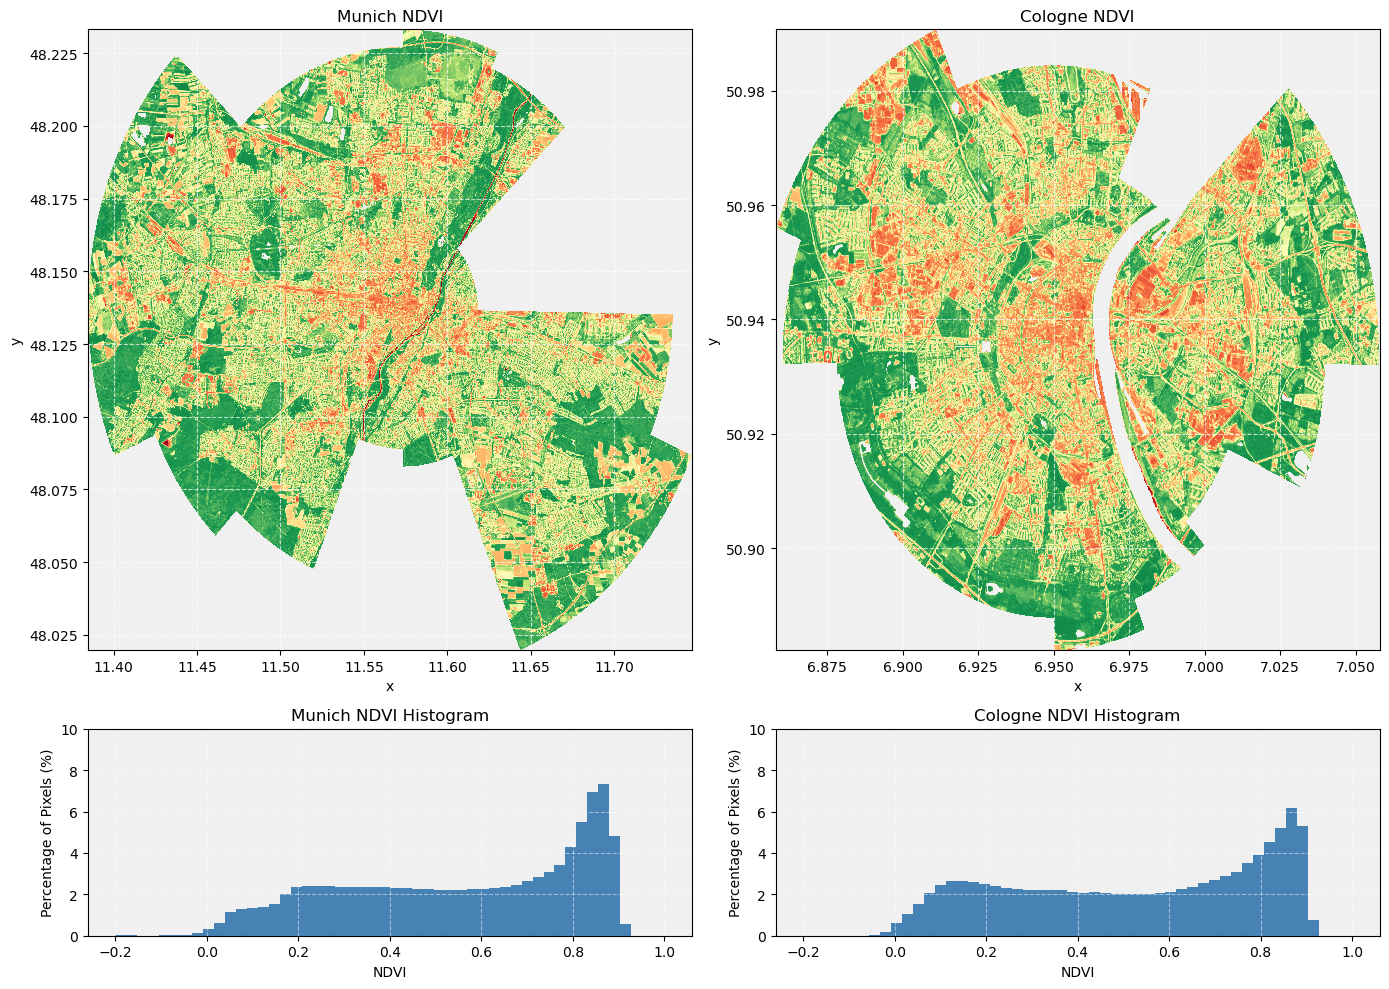

In [31]:
#--------NDVI AND RGB NETCDF4 CONVERSION-----------------
if os.path.exists("../data/munich_ndvi.tif") and os.path.exists("../data/cologne_ndvi.tif"):
    munich_p="../data/munich.tif"
    cologne_p="../data/cologne.tif"

    munich=rxr.open_rasterio(munich_p).isel(band=4).squeeze() 
    cologne=rxr.open_rasterio(cologne_p).isel(band=4).squeeze()

    munich.to_netcdf("../data/munich_ndvi.nc")
    cologne.to_netcdf("../data/cologne_ndvi.nc")
else:
    print("Tifs dont exist (most likely already converted to netcdf and deleted - Skipping this step)")



#---------LST NETCDF4 CONVERSION-----------------

if os.path.exists("../data/munich_lst.tif") and os.path.exists("../data/cologne_lst.tif"):
    munich_lst_p="../data/munich_lst.tif"
    cologne_lst_p="../data/cologne_lst.tif"

    munich_lst=xr.open_dataarray(munich_lst_p).squeeze().to_netcdf("../data/munich_lst.nc")
    cologne_lst=xr.open_dataarray(cologne_lst_p).squeeze().to_netcdf("../data/cologne_lst.nc")
    print("LST Conversion for munich and cologne completed")
else:
    print("LST Tifs dont exist (most likely already converted to netcdf and deleted - Skipping this step)")



#--------REMOVE OLD FILES-----------------
files = [
    ("../data/munich.tif", "converted munich tif"),
    ("../data/cologne.tif", "converted cologne tif"),
    ("../data/munich_lst.tif", "converted munich lst tif"),
    ("../data/cologne_lst.tif", "converted cologne lst tif"),
]

for filepath, description in files:
    if os.path.exists(filepath):
        print(f"Removing {description}")
        os.remove(filepath)
    else:
        print(f"{description} not found, skipping removal")


#open netcdf files 
munich=xr.open_dataset("../data/munich_ndvi.nc")
munich = munich["__xarray_dataarray_variable__"].rename("ndvi").rio.write_crs("EPSG:4326").drop_vars("band")
cologne=xr.open_dataset("../data/cologne_ndvi.nc")
cologne = cologne["__xarray_dataarray_variable__"].rename("ndvi").rio.write_crs("EPSG:4326").drop_vars("band")
munich_lst=xr.open_dataset("../data/munich_lst.nc")
munich_lst = munich_lst["__xarray_dataarray_variable__"].rename("lst").rio.write_crs("EPSG:4326").drop_vars("band")
cologne_lst=xr.open_dataset("../data/cologne_lst.nc")
cologne_lst = cologne_lst["__xarray_dataarray_variable__"].rename("lst").rio.write_crs("EPSG:4326").drop_vars("band")

#--------PLOTTING-----------------
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1])  # maps taller than histograms


# --- Munich map ---
ax0 = fig.add_subplot(gs[0, 0])
munich.plot(ax=ax0, cmap='RdYlGn', vmin=-0.2, vmax=1, add_colorbar=False)
ax0.set_title('Munich NDVI')
ax0.set_facecolor("#f0f0f0")
ax0.grid(True, which="both", linestyle="--", color="white", alpha=0.7)

# --- Munich histogram ---
ax1 = fig.add_subplot(gs[1, 0])
n, bins, _ = ax1.hist(
    munich.values.ravel(),
    bins=50,
    range=(-0.2, 1),
    color='steelblue',
    density=True,
)
bin_width = bins[1] - bins[0]
n_percent = n * bin_width * 100
ax1.cla()  # clear old histogram
ax1.bar(bins[:-1], n_percent, width=bin_width, color='steelblue', align='edge')
ax1.set_title('Munich NDVI Histogram')
ax1.set_xlabel('NDVI')
ax1.set_ylabel('Percentage of Pixels (%)')
ax1.set_ylim(0, 10)
ax1.set_facecolor("#f0f0f0")
ax1.grid(True, which="both", linestyle="--", color="white", alpha=0.5)

# --- Cologne map ---
ax2 = fig.add_subplot(gs[0, 1])
cologne.plot(ax=ax2, cmap='RdYlGn', vmin=-0.2, vmax=1, add_colorbar=False)
ax2.set_title('Cologne NDVI')
ax2.set_facecolor("#f0f0f0")
ax2.grid(True, which="both", linestyle="--", color="white", alpha=0.7)

# --- Cologne histogram ---
ax3 = fig.add_subplot(gs[1, 1])
n, bins, _ = ax3.hist(
    cologne.values.ravel(),
    bins=50,
    range=(-0.2, 1),
    color='steelblue',
    density=True,
)
n_percent = n * bin_width * 100
ax3.cla()  # clear old histogram
ax3.bar(bins[:-1], n_percent, width=bin_width, color='steelblue', align='edge')
ax3.set_title('Cologne NDVI Histogram')
ax3.set_xlabel('NDVI')
ax3.set_ylabel('Percentage of Pixels (%)')
ax3.set_ylim(0, 10)
ax3.set_facecolor("#f0f0f0")
ax3.grid(True, which="both", linestyle="--", color="white", alpha=0.5)

plt.tight_layout()
plt.show()

# Datacube Creation and spatial correlation
We will now employ Xarray to look for a spatial correlation between **LST** and **NDVI**

In [35]:
munich_ndvi=munich.rio.reproject_match(munich_lst, resampling=Resampling.average)
ds_munich=xr.Dataset({
    "ndvi": munich_ndvi,
    "lst": munich_lst
})

cologne_ndvi=cologne.rio.reproject_match(cologne_lst, resampling=Resampling.average)
ds_cologne=xr.Dataset({
    "ndvi": cologne_ndvi,
    "lst": cologne_lst
})


ds_munich

<xarray.Dataset> Size: 1MB
Dimensions:      (x: 403, y: 238)
Coordinates:
    spatial_ref  int64 8B 0
  * x            (x) float64 3kB 11.38 11.39 11.39 11.39 ... 11.74 11.75 11.75
  * y            (y) float64 2kB 48.23 48.23 48.23 48.23 ... 48.02 48.02 48.02
Data variables:
    ndvi         (y, x) float32 384kB nan nan nan nan nan ... nan nan nan nan
    lst          (y, x) float64 767kB ...

In [36]:
#convert to np arrays
ndvi_munich = ds_munich.ndvi.values
lst_munich = ds_munich.lst.values

ndvi_cologne = ds_cologne.ndvi.values
lst_cologne = ds_cologne.lst.values


In [43]:
from libpysal.weights import lat2W, w_subset

# Create full weights matrix
w = lat2W(rows, cols, rook=False)

# Get indices of valid pixels
valid_indices = np.where(valid)[0]

# Correct way: subset using w_subset function
w_valid = w_subset(w, valid_indices)

# Compute Moran's I
moran_ndvi = Moran(ndvi_valid, w_valid)

print(f"Global Moran's I NDVI (Munich): {moran_ndvi.I:.3f}, p-value: {moran_ndvi.p_sim:.4f}")


Global Moran's I NDVI (Munich): 0.720, p-value: 0.0010
